# Import ...

In [2]:
from structJsonOutput.struct_text_generate import struct_generate
import time
from retrying import retry
import sys
from product2Image import getPipelineResults
import json
import os


# using Gemini api (sometimes failed)
@retry(stop_max_attempt_number=2)
def promptGeneration(img_path, save_path, feedback_path='', if_save=True):
    # record and save processed result
    process_results = {}
    
    # img -> img_description
    narrator_out = struct_generate(img_path, gen_type='narrator')
    process_results['narrator'] = narrator_out
    time.sleep(1)

    # img_description -> relevant background description
    img_desc = narrator_out['desc']
    object_name = narrator_out['object_name']
    viewpoint = narrator_out['viewpoint']
    feedback = '' 
    prompt = [img_desc,object_name,viewpoint,feedback ]
    divergent_out = struct_generate(prompt, gen_type='divergent')
    process_results['divergent'] = divergent_out
    time.sleep(1)
    
    # description relevant sort
    scene_descs = divergent_out['scenes']
    pgenerator_out = struct_generate([scene_descs, img_desc], gen_type='pgenerator')
    process_results['pgenerator'] = pgenerator_out
    time.sleep(1)
    
    # final prompt
    prompts_results = list(zip(pgenerator_out['scenes'],pgenerator_out['rank']))
    prompts_results.sort(key=lambda x:x[1])
    process_results['prompts'] = prompts_results

    # save process results
    if if_save:
        with open(save_path, 'w') as f:
            json.dump(process_results, f)
    
    return process_results

def imageGeneration(img_path, prompts, num_per_prompt=2):
    results = getPipelineResults(img_path,prompts,num_per_prompt=num_per_prompt)
    return results

def saveResultImages(results, save_dir):
    """
    results: [
            original_img:PIL.Image, 
            image_results: List[List[PIL.Image, PIL.Image]], 
            inpaint_results: List[List[PIL.Image, float]],
            ]
    """
    orig_img, image_results, inpaint_results = results
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    orig_img.save(os.path.join(save_dir,'ori.png'))
    print(f'#result: {len(image_results)}, #inpaint_results: {len(inpaint_results)}')
    [(image_results[i].save(os.path.join(save_dir, f'{str(i)}_temp.png')), image_results[i+1].save(os.path.join(save_dir, f'{str(i)}_paste.png'))) for i in range(0,len(image_results),2)]
    #[(post_results[i].save(os.path.join(save_dir, f'post_{str(i)}_temp.png')), post_results[i+1].save(os.path.join(save_dir, f'post_{str(i)}_paste.png'))) for i in range(0,len(post_results),2)]
    [inpaint_results[i][0].save(os.path.join(save_dir, f'inp_{str(i)}_{str(round(inpaint_results[i][1],4))}.png')) for i in range(0,len(inpaint_results))]


/home/test/miniconda3/envs/anywhere/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prompt Generation

## prompt generation for single image

In [3]:
# prompt generation for single image
import os
from PIL import Image
from tqdm import tqdm

img_path = 'examples/imgs/blender.png'
save_path = 'examples/prompt_outputs/blender1.json'
prompts_results = promptGeneration(img_path, save_path)

[{'desc': 'This is a white plastic and glass blender. It has a clear glass jar with a white plastic lid. The lid has a black button on it. The base of the blender is white plastic. It has a cord coming out of the back of it.', 'object_name': 'blender', 'viewpoint': 'front'}]  {"desc":"This is a white plastic and glass blender. It has a clear glass jar with a white plastic lid. The lid has a black button on it. The base of the blender is white plastic. It has a cord coming out of the back of it.","object_name":"blender","viewpoint":"front"}
None {"scenes":["1. **Scene 1:** The blender is on a white kitchen counter in front of a white tile backsplash. There is a bowl of fruit on the counter next to the blender. The kitchen is well-lit and has a modern design. The blender is turned on and is blending a smoothie.
2. **Scene 2:** The blender is on a wooden table in a rustic kitchen. There is a window behind the blender that looks out onto a garden. The kitchen is warm and inviting. The blen

## prompt generation for batch images

In [ ]:
# prompt generation for batch images
import os
from PIL import Image
from tqdm import tqdm

file_dir = 'examples/imgs' # contain images files
save_dir = 'examples/prompt_outputs' # prompt results save dir
# feedback_dir = 'experiment_result/feedback_term1' # feedback prompt dir

for name in tqdm(os.listdir(file_dir)):
    file_path = os.path.join(file_dir, name)
    save_path = os.path.join(save_dir, name.split('.')[0]+'.json')
    # feedback_path = os.path.join(feedback_dir, name.split('.')[0]+'.json')
    if os.path.exists(save_path):
        continue
    try:
        # promptGeneration(file_path, save_path, feedback_path)
        promptGeneration(file_path, save_path)
    except:
        print('error in:',file_path)
        continue

# Image generation

## image generation for single image

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
import sys

# load prompt from previous step
prompts = ['']
with open('examples/prompt_outputs/blender.json','r') as f:
    prompts_results = json.load(f)
# get top3 scene description
prompts = [x[0] for x in prompts_results['prompts'][:2]]
prompts

['A white blender is placed on a minimalist white kitchen counter against a light gray wall. A gray tea kettle is on the left and a wooden bowl filled with limes is in the background.',
 'The blender is set on a white marble counter. A fruit bowl with bananas, strawberries, and grapes sits next to it. The backdrop is a large window with a view of a city.']

In [3]:
img_path = 'examples/imgs/blender.png'
num_per_prompt = 2
img_results = imageGeneration(img_path, prompts)

Remove background using RMBG-1.4 ...


  0%|                                                                                             | 0/50 [00:00<?, ?it/s]/home/test/miniconda3/envs/anywhere/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.018111621303099505
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.018111621303099505
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.04130806542425398


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:19<00:00,  2.56it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.025266743370321282
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.021636725430059206
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.021636725430059206
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.03640509321592312


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:18<00:00,  2.62it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.03140420144851005
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.030253646629294036
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.030253646629294036


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:18<00:00,  2.61it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.029071617666087308
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.030064801765349765
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.013397493958712918
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.013397493958712918


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.88it/s]


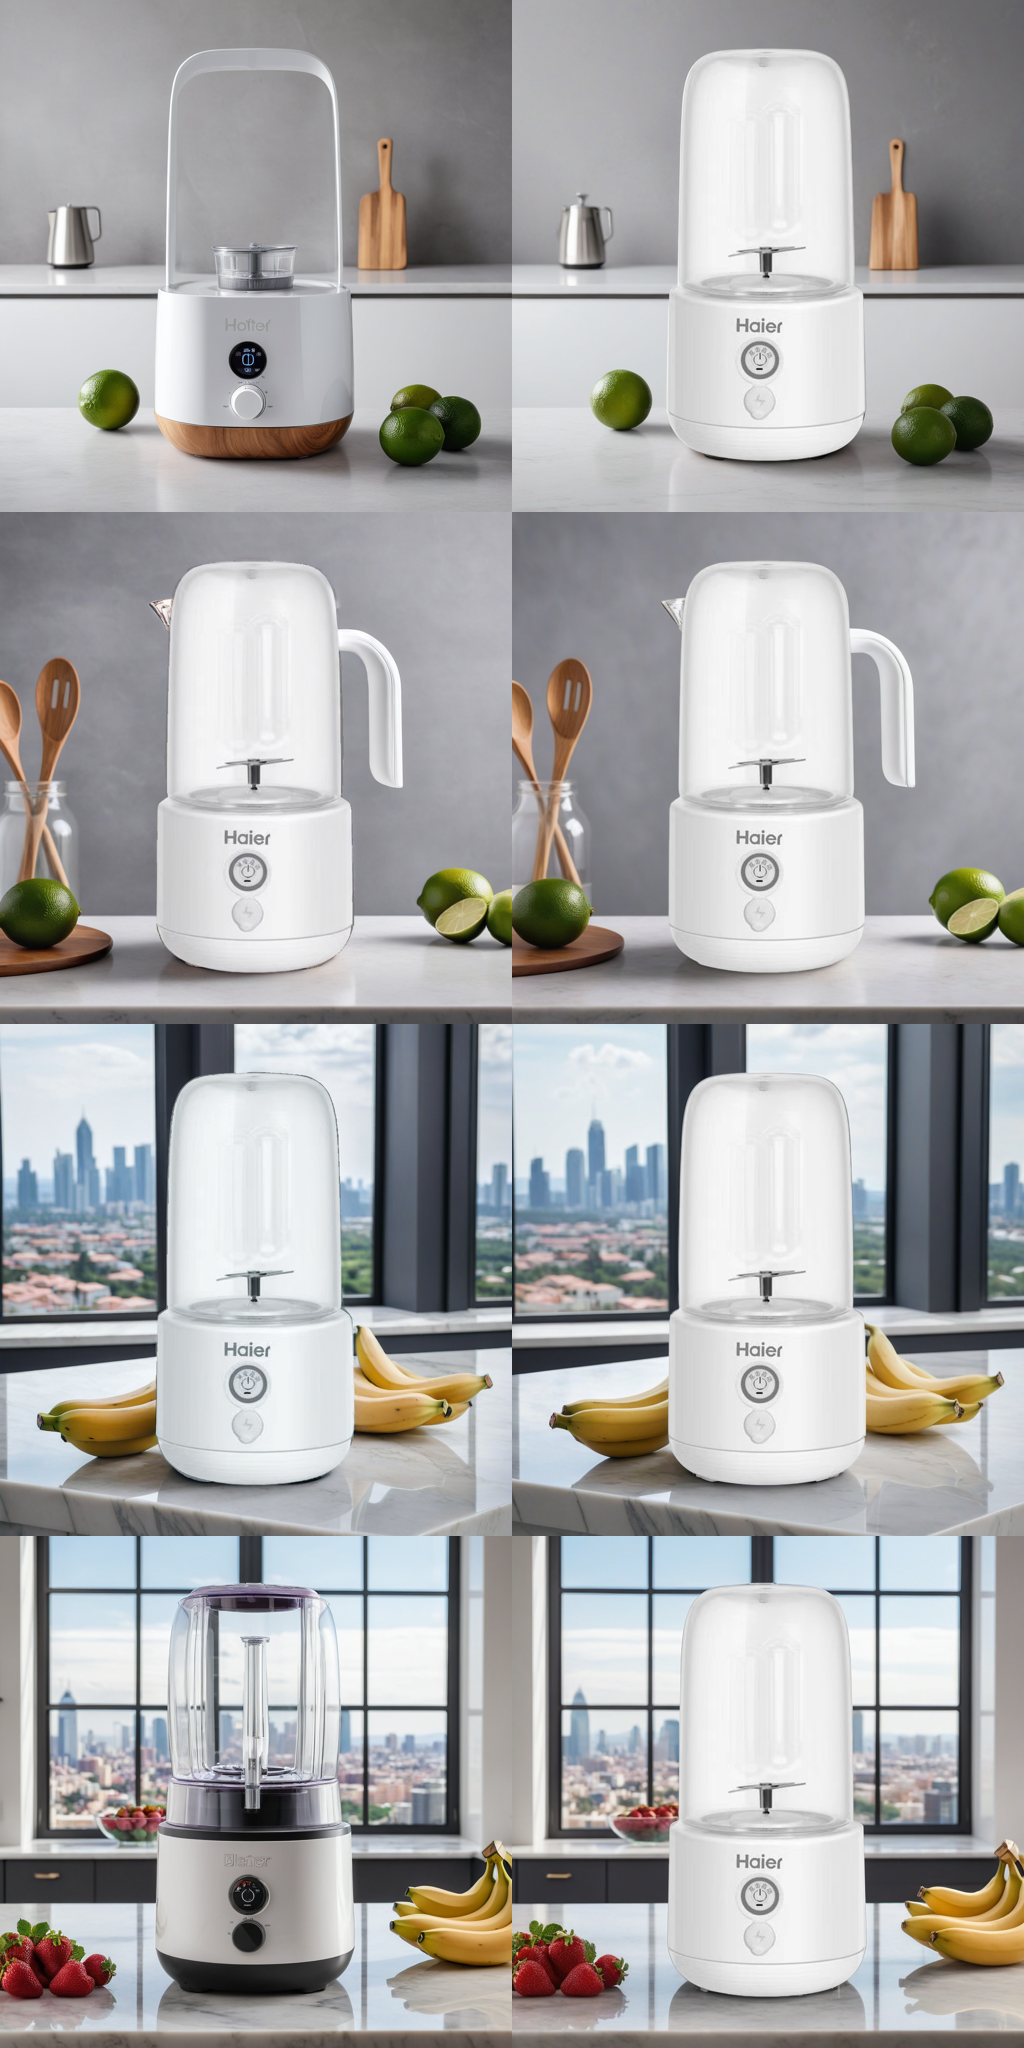

In [4]:
from diffusers.utils import make_image_grid
make_image_grid(img_results[1], rows=len(prompts)*2, cols=2, resize=512)

# Full Pipeline (Prompt Generation + Image Generation)

[{'desc': 'This is a white plastic and glass food chopper. It has a clear glass jar with a white plastic lid. The lid has a black button on it. The base of the chopper is white plastic. It has a cord coming out of the back of it.', 'object_name': 'food chopper', 'viewpoint': 'front'}]  {"desc":"This is a white plastic and glass food chopper. It has a clear glass jar with a white plastic lid. The lid has a black button on it. The base of the chopper is white plastic. It has a cord coming out of the back of it.","object_name":"food chopper","viewpoint":"front"}
None {"scenes": ["1. The food chopper is placed on a white kitchen counter in front of a window. The window is open and the sun is streaming in, casting a warm glow on the chopper. The chopper is surrounded by fresh fruits and vegetables, such as apples, bananas, and carrots.
2. The food chopper is placed on a wooden cutting board in front of a sink. The sink is full of water and the faucet is running. The chopper is surrounded by

  0%|                                                                                             | 0/50 [00:00<?, ?it/s]/home/test/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (88 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['professional product photos, high quality, reali

Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.017667486160119462
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.017667486160119462
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.018982405953509193
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.018982405953509193
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.0382970389824759


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:19<00:00,  2.56it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.04749098615487377
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.05112100409513585
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.04749098615487377


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:18<00:00,  2.61it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.03339056964703496
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.04922206407436291
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.02797701688063256
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.02797701688063256
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.03297091439382547


100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:18<00:00,  2.60it/s]


Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.02872889920929956
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.028634476777327427
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.028634476777327427
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.014939727014257788
Remove background using RMBG-1.4 ...
Unoverlap_rate: 0.014939727014257788


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.96it/s]


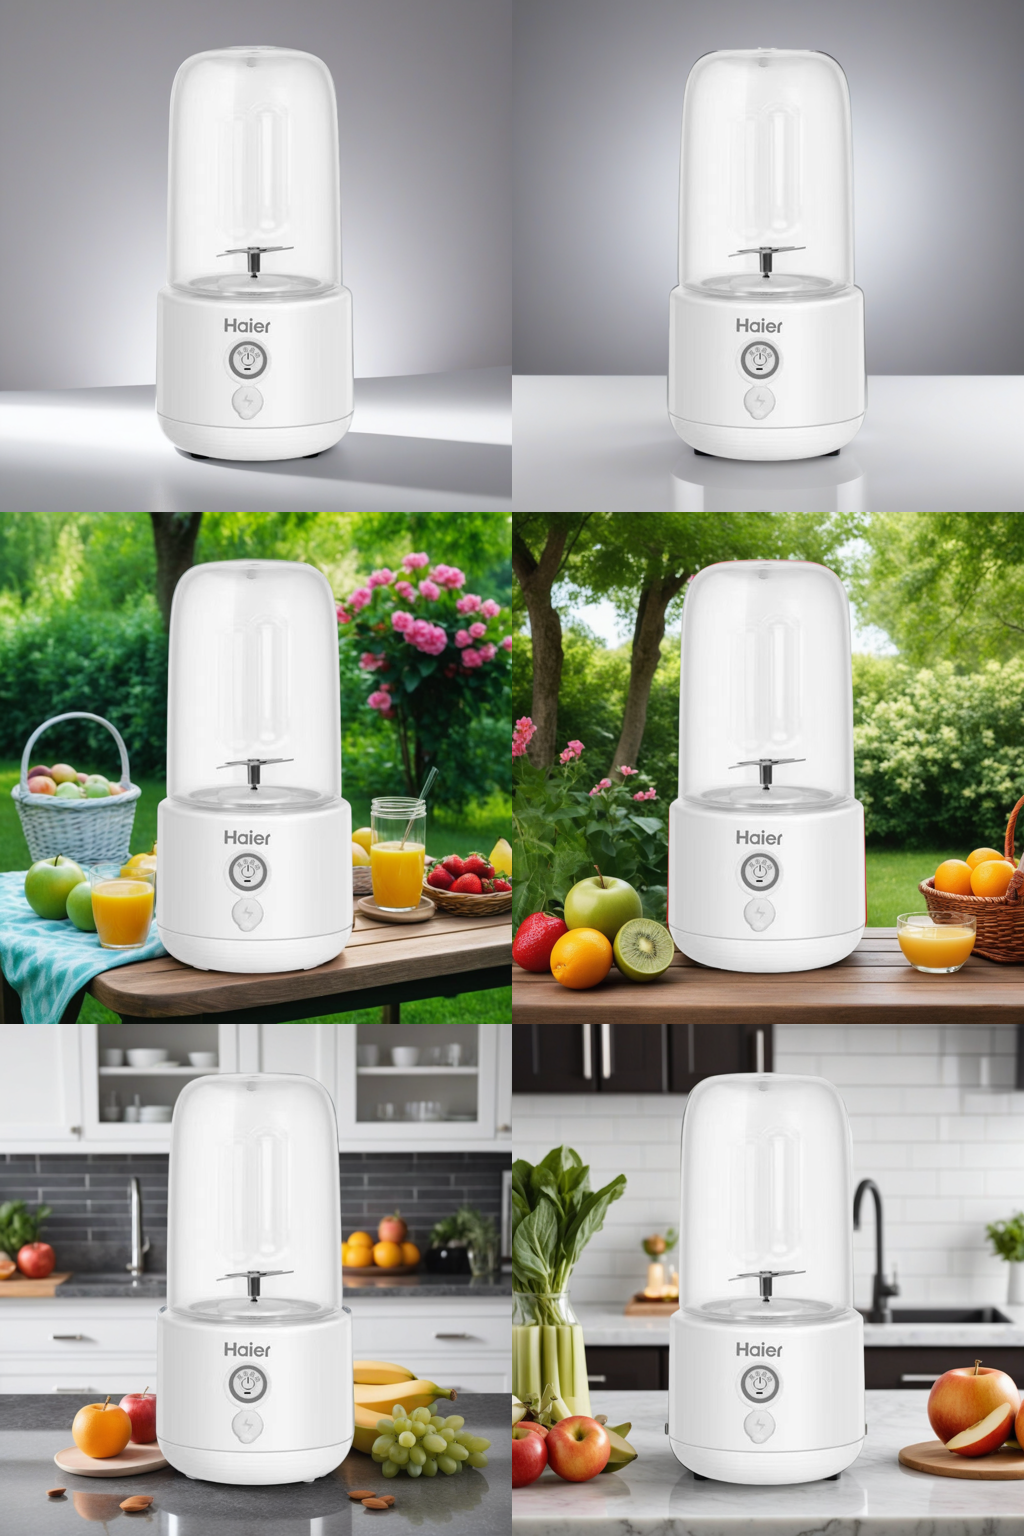

In [2]:
img_path = 'examples/imgs/blender.png'
save_path = 'examples/prompt_outputs/blender.json'

# for Prompt Generation
prompts_results = promptGeneration(img_path, save_path, if_save=False)

# for Image Generation
topN = 2
prompts = [x[0] for x in prompts_results['prompts'][:topN]] # get topN scene description
num_per_prompt = 2
img_results = imageGeneration(img_path, prompts)

# plot results 
from diffusers.utils import make_image_grid
results = [x for i,x in enumerate(img_results[1]) if i%2!=0]
make_image_grid(results, rows=len(prompts), cols=num_per_prompt, resize=512)

# Feedback (Outcome Analyzer)

# for single image result

In [20]:
from structJsonOutput.struct_text_generate import struct_generate
import time
import json
from PIL import Image
import glob
import os
from tqdm import tqdm


img_path = './examples/image_outputs/blender_0.png'
prompt_path = './examples/prompt_outputs/blender.json'


res={}

with open(prompt_path, 'r') as f:
    prompt_results = json.load(f)
obj_name = prompt_results['narrator']['object_name']

img = Image.open(img_path)
prompt = [obj_name, img]
# You can define your own question in `struct_text_generate` file
checker_out = struct_generate(prompt, gen_type='checker')
res['checker'] = checker_out

[{'ques': ['Is it common for food chopper to be placed in this context?', 'Is food chopper placed normally on a platform or on the ground?'], 'ans': ['Yes, it is a food chopper placed on a kitchen counter.', 'Normally, it is placed on a platform.']}]  ```json
{
  "ques": ["Is it common for food chopper to be placed in this context?", "Is food chopper placed normally on a platform or on the ground?"],
  "ans": ["Yes, it is a food chopper placed on a kitchen counter.", "Normally, it is placed on a platform."]
}
```


In [21]:
# save feedback results
with open('./examples/feedback_outputs/blender_0.json','w') as f:
    json.dump(res, f)

# Using feedback result for multi-round prompt/image generation

In [26]:
from structJsonOutput.struct_text_generate import struct_generate
import time
from retrying import retry
import sys
import json
import os

@retry(stop_max_attempt_number=2)
def multiTermPromptGeneration(prompt_path, save_path, feedback_path):
    # record and save process result
    process_results = {}

    # read previous prompts results
    with open(prompt_path, 'r') as f:
        prompt_results = json.load(f)
    # read previous term feedback results
    with open(feedback_path, 'r') as f:
        fb_res = json.load(f)

    # You can define your own question in `struct_text_generate` file
    q1 = fb_res['checker']['ques'][0] + ' ' + ' '.join([fb_res[x]['ans'][0] for x in fb_res])
    q2 = fb_res['checker']['ques'][1] + ' ' + ' '.join([fb_res[x]['ans'][1] for x in fb_res])
    feedback = q1+q2
    narrator_out = prompt_results['narrator']

    
    process_results['narrator'] = narrator_out
    # img_description -> relevant background description
    img_desc = narrator_out['desc']
    object_name = narrator_out['object_name']
    viewpoint = narrator_out['viewpoint']
    feedback = ''
    prompt = [img_desc,object_name,viewpoint,feedback ]
    divergent_out = struct_generate(prompt, gen_type='divergent')
    process_results['divergent'] = divergent_out
    time.sleep(1)
    
    # description relevant sort
    scene_descs = divergent_out['scenes']
    pgenerator_out = struct_generate([scene_descs, img_desc], gen_type='pgenerator')
    process_results['pgenerator'] = pgenerator_out
    time.sleep(1)
    
    # final prompt
    prompts_results = list(zip(pgenerator_out['scenes'],pgenerator_out['rank']))
    prompts_results.sort(key=lambda x:x[1])
    process_results['prompts'] = prompts_results

    # save process results
    with open(save_path, 'w') as f:
        json.dump(process_results, f)
    
    return prompts_results

In [27]:
# second round prompt generation for from previous round
import os
from PIL import Image
from tqdm import tqdm

prompt_path = 'examples/prompt_outputs/blender.json'
save_path = 'examples/prompt_outputs_round2/blender.json'
feedback_path = 'examples/feedback_outputs/blender_0.json'

multiTermPromptGeneration(prompt_path, save_path, feedback_path)


None {"scenes":["1. The food chopper is placed on a white kitchen counter in front of a window. The sun is shining through the window and casting a shadow on the food chopper.


2. The food chopper is sitting on a wooden cutting board on top of a kitchen counter. There are some vegetables scattered around the cutting board.


3. The food chopper is placed on a white tablecloth in the center of a dining table. There are plates and silverware set out on the table.


4. The food chopper is sitting on a shelf in a kitchen pantry. There are other kitchen appliances and supplies on the shelves.


5. The food chopper is placed on a black countertop in a commercial kitchen. There are other appliances and equipment in the kitchen."]}
[{'scenes': ['1. The food chopper is placed on a white kitchen counter in front of a window. The sunlight streams in through the window and illuminates the food chopper, casting intricate shadows across its surface.', '2. The food chopper is placed on a wooden cutt

[('1. The food chopper is placed on a white kitchen counter in front of a window. The sunlight streams in through the window and illuminates the food chopper, casting intricate shadows across its surface.',
  0),
 ('5. The food chopper is placed on a stainless steel counter in a commercial kitchen. The kitchen is bustling with activity, and chefs are preparing food in the background.',
  1),
 ('2. The food chopper is placed on a wooden cutting board on top of a kitchen island. The kitchen is modern and spacious, with white cabinets and stainless steel appliances.',
  2),
 ('3. The food chopper is placed on a metal tray in the center of a rustic wooden table. The table is surrounded by wooden chairs and a vintage chandelier hangs overhead.',
  3),
 ('4. The food chopper is placed on a white tablecloth on a dining table. The table is set for dinner with plates, silverware, and glasses.',
  4)]

In [31]:
# Image generation (the same...
...